# Aviation Risk Analysis for Safe Aircraft Acquisition

## Introduction
This Jupyter Notebook examines historical aviation accident data from the National Transportation Safety Board (NTSB). The goal is to find low-risk aircraft for a company starting a new aviation division. We aim to give data-driven suggestions for buying safe aircraft, reducing safety risks and liabilities. Using Python, pandas, numpy, and matplotlib, we will clean, preprocess, analyze, and visualize the data. This process will help us assess accident rates, injury severities, and contributing factors. This document is tailored for a data science audience familiar with Python and data analysis, offering a straightforward and reproducible workflow with Markdown for context and Python for execution. All cells can be run in sequence after restarting the kernel. The notebook will be submitted as a PDF on Canvas and as an `.ipynb` file in a GitHub repository.


## Business Understanding
The company, new to the aviation sector, seeks to acquire aircraft for both commercial and private use while minimizing safety risks. The challenge is to pinpoint makes, models, or categories of aircraft with the lowest accident and injury rates, answering these questions:
- Which aircraft have the lowest accident and injury rates?
- What factors, such as weather or flight phase, contribute to risks?
- Which aircraft should the company focus on acquiring?

The main stakeholder, the head of the aviation division, needs practical insights to support purchasing decisions. This analysis uses NTSB data to propose low-risk aircraft, ensuring a safe entry into the market.


## Data Understanding
### Data Source
The dataset, `AviationData.csv`, is sourced from [Kaggle](https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses). It contains 88,889 records of civil aviation accidents and incidents in the U.S. and international waters from 1962 to 2023. The dataset has 31 columns, including:
- **Event Details**: `Event.Id`, `Investigation.Type`, `Accident.Number`, `Event.Date`
- **Geographical Data**: `Location`, `Country`, `Latitude`, `Longitude`, `Airport.Code`, `Airport.Name`
- **Injury Statistics**: `Total.Fatal.Injuries`, `Total.Serious.Injuries`, `Total.Minor.Injuries`, `Total.Uninjured`
- **Aircraft Information**: `Make`, `Model`, `Aircraft.Category`, `Registration.Number`, `Amateur.Built`, `Number.of.Engines`, `Engine.Type`, `Aircraft.damage`
- **Flight Details**: `Purpose.of.flight`, `Air.carrier`, `Schedule`, `FAR.Description`, `Weather.Condition`, `Broad.phase.of.flight`
- **Report Details**: `Report.Status`, `Publication.Date`


### Initial Exploration
We load the dataset and examine its structure to understand its contents and identify issues like missing values, mixed data types, and 'unknown' values.


In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/AviationData.csv', encoding='latin1', low_memory=False)

# Display shape and first five rows
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (88889, 31)


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


Columns include Event.Id, Event.Date, Location, Make, Model, injury counts, etc., with missing values in Latitude, Longitude, Airport.Code, and 'unknown' or 'UNK' in fields like Weather.Condition.

###Data Challenges

Missing Values: There are significant null values in Latitude (54,507), Longitude (54,516), Airport.Code (38,549), Air.carrier (72,022), and others.
Mixed Data Types: Columns like Latitude and Longitude have mixed types, leading to a DtypeWarning.
'Unknown' Values: Categorical fields such as Weather.Condition (e.g., 'UNK'), Broad.phase.of.flight (e.g., 'Unknown'), and Aircraft.Category have 'unknown' values that could impact the analysis.
Temporal Span: Data from 1962 to 2023 includes outdated aircraft, requiring filtering for modern relevance.



In [11]:
# Check missing values and 'unknown' values
print("Missing Values:")
print(df.isna().sum())
print("\n'Unknown' Values in Key Columns:")
for col in ['Weather.Condition', 'Broad.phase.of.flight', 'Aircraft.Category']:
    print(f"{col}: {(df[col].str.lower() == 'unknown').sum() + (df[col] == 'UNK').sum()}")

Missing Values:
Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38757
Airport.Name              36185
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1382
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7096
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6384
Publication.Date        

##Data Preparation
Cleaning and Imputation
We will ensure data quality by cleaning the dataset, addressing missing values, correcting data types, and creating new features:

###Dropping Rows: Remove rows missing critical fields, such as Location, Country, Make, Model, and Amateur.Built, to maintain data integrity.

###Numerical Imputation:
For Latitude and Longitude, convert to numeric and fill in with medians.
For injury columns (Total.Fatal.Injuries, etc.), fill with 0, assuming no injuries if data is missing.
For Number.of.Engines, fill with the median.


####Categorical Imputation:
We will fill all categorical columns (Airport.Code, Airport.Name, Aircraft.Category, FAR.Description, Schedule, Broad.phase.of.flight, Registration.Number, Air.carrier, Injury.Severity, Aircraft.damage, Engine.Type, Purpose.of.flight, Weather.Condition, Report.Status, Publication.Date) with their respective mode values to maintain consistency and lessen the occurrence of 'unknown' values.


###Type Conversion: Convert Event.Date to datetime and ensure that injury columns are integers.
Feature Engineering: Extract Event.Year from Event.Date for temporal analysis.
Duplicate Check: Confirm there are no duplicate rows.


In [12]:
# Drop rows with missing critical fields
df = df.dropna(subset=['Location', 'Country', 'Make', 'Model', 'Amateur.Built'])

# Impute numerical columns
# Inspect unique values before conversion
print("Unique values in Latitude before conversion:")
print(df['Latitude'].unique()[:20]) # Print first 20 unique values
print("\nUnique values in Longitude before conversion:")
print(df['Longitude'].unique()[:20]) # Print first 20 unique values

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Latitude'] = df['Latitude'].fillna(df['Latitude'].median())
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['Longitude'] = df['Longitude'].fillna(df['Longitude'].median())
for col in ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']:
    df[col] = df[col].fillna(0).astype(int)
df['Number.of.Engines'] = df['Number.of.Engines'].fillna(df['Number.of.Engines'].median())

# Impute all categorical columns with their respective mode
categorical_columns = ['Airport.Code', 'Airport.Name', 'Aircraft.Category', 'FAR.Description',
                      'Schedule', 'Broad.phase.of.flight', 'Registration.Number', 'Air.carrier',
                      'Injury.Severity', 'Aircraft.damage', 'Engine.Type', 'Purpose.of.flight',
                      'Weather.Condition', 'Report.Status', 'Publication.Date']
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert data types
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
df['Event.Year'] = df['Event.Date'].dt.year

# Check for duplicates
print(f"Duplicates: {df.duplicated().sum()}")

# Verify no missing values
print(f"Final Shape: {df.shape}")
print("Missing Values After Cleaning:")
print(df.isna().sum())

# Re-check 'unknown' values
print("\n'Unknown' Values After Cleaning:")
for col in ['Weather.Condition', 'Broad.phase.of.flight', 'Aircraft.Category']:
    print(f"{col}: {(df[col].str.lower() == 'unknown').sum() + (df[col] == 'UNK').sum()}")

Unique values in Latitude before conversion:
[nan '36.922223' '42.445277' '30.757778' '46.041111' '48.12' '38.54'
 '46.154444' '70.333333' '30.383611' '38.335' '45.928334' '29.607222'
 '35.389722' '33.948611' '64.8' '41.908889' '47.852222' '33.938611'
 '38.981667']

Unique values in Longitude before conversion:
[nan '-81.878056' '-70.758333' '-88.355555' '-120.849722' '-113.8875'
 '-173.24' '-85.663611' '-150.933333' '-103.783334' '-80.28' '-84.825556'
 '-95.158611' '-83.920556' '-118.413611' '-147.866111' '-70.728611'
 '-116.475278' '-118.408889' '-119.672778']


/tmp/ipython-input-12-3826404965.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
/tmp/ipython-input-12-3826404965.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Latitude'] = df['Latitude'].fillna(df['Latitude'].median())
/tmp/ipython-input-12-3826404965.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Duplicates: 0
Final Shape: (88406, 32)
Missing Values After Cleaning:
Event.Id                  0
Investigation.Type        0
Accident.Number           0
Event.Date                0
Location                  0
Country                   0
Latitude                  0
Longitude                 0
Airport.Code              0
Airport.Name              0
Injury.Severity           0
Aircraft.damage           0
Aircraft.Category         0
Registration.Number       0
Make                      0
Model                     0
Amateur.Built             0
Number.of.Engines         0
Engine.Type               0
FAR.Description           0
Schedule                  0
Purpose.of.flight         0
Air.carrier               0
Total.Fatal.Injuries      0
Total.Serious.Injuries    0
Total.Minor.Injuries      0
Total.Uninjured           0
Weather.Condition         0
Broad.phase.of.flight     0
Report.Status             0
Publication.Date          0
Event.Year                0
dtype: int64

'Unknown' Values Aft

##Data Preparation
###Cleaning and Imputation
We will ensure data quality by cleaning the dataset, addressing missing values, correcting data types, and creating new features:

####Dropping Rows: Remove rows missing critical fields, such as Location, Country, Make, Model, and Amateur.Built, to maintain data integrity.
Numerical Imputation:
For Latitude and Longitude, convert to numeric and fill in with medians.
For injury columns (Total.Fatal.Injuries, etc.), fill with 0, assuming no injuries if data is missing.
For Number.of.Engines, fill with the median.


##Categorical Imputation:
We will fill all categorical columns (Airport.Code, Airport.Name, Aircraft.Category, FAR.Description, Schedule, Broad.phase.of.flight, Registration.Number, Air.carrier, Injury.Severity, Aircraft.damage, Engine.Type, Purpose.of.flight, Weather.Condition, Report.Status, Publication.Date) with their respective mode values to maintain consistency and lessen the occurrence of 'unknown' values.

Type Conversion: Convert Event.Date to datetime and ensure that injury columns are integers.
Feature Engineering: Extract Event.Year from Event.Date for temporal analysis.
Duplicate Check: Confirm there are no duplicate rows.

In [13]:
# Drop rows with missing critical fields
df = df.dropna(subset=['Location', 'Country', 'Make', 'Model', 'Amateur.Built'])

# Impute numerical columns
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce').fillna(df['Latitude'].median())
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce').fillna(df['Longitude'].median())
for col in ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']:
    df[col] = df[col].fillna(0).astype(int)
df['Number.of.Engines'] = df['Number.of.Engines'].fillna(df['Number.of.Engines'].median())

# Impute all categorical columns with their respective mode
categorical_columns = ['Airport.Code', 'Airport.Name', 'Aircraft.Category', 'FAR.Description',
                      'Schedule', 'Broad.phase.of.flight', 'Registration.Number', 'Air.carrier',
                      'Injury.Severity', 'Aircraft.damage', 'Engine.Type', 'Purpose.of.flight',
                      'Weather.Condition', 'Report.Status', 'Publication.Date']
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Convert data types
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
df['Event.Year'] = df['Event.Date'].dt.year

# Check for duplicates
print(f"Duplicates: {df.duplicated().sum()}")

# Verify no missing values
print(f"Final Shape: {df.shape}")
print("Missing Values After Cleaning:")
print(df.isna().sum())

# Re-check 'unknown' values
print("\n'Unknown' Values After Cleaning:")
for col in ['Weather.Condition', 'Broad.phase.of.flight', 'Aircraft.Category']:
    print(f"{col}: {(df[col].str.lower() == 'unknown').sum() + (df[col] == 'UNK').sum()}")

Duplicates: 0
Final Shape: (88406, 32)
Missing Values After Cleaning:
Event.Id                  0
Investigation.Type        0
Accident.Number           0
Event.Date                0
Location                  0
Country                   0
Latitude                  0
Longitude                 0
Airport.Code              0
Airport.Name              0
Injury.Severity           0
Aircraft.damage           0
Aircraft.Category         0
Registration.Number       0
Make                      0
Model                     0
Amateur.Built             0
Number.of.Engines         0
Engine.Type               0
FAR.Description           0
Schedule                  0
Purpose.of.flight         0
Air.carrier               0
Total.Fatal.Injuries      0
Total.Serious.Injuries    0
Total.Minor.Injuries      0
Total.Uninjured           0
Weather.Condition         0
Broad.phase.of.flight     0
Report.Status             0
Publication.Date          0
Event.Year                0
dtype: int64

'Unknown' Values Aft

##Data Quality Notes

'Unknown' Values: While imputing with mode reduces reliance on 'unknown' values, it does not completely eliminate them (e.g., Aircraft.Category still has ~39,500 'unknown' values from the original dataset). This may introduce bias by over-representing the mode (e.g., 'Airplane' for Aircraft.Category). However, this approach ensures consistency and minimizes missing data for analysis. Although these values limit secondary analyses, they do not affect the core aircraft risk assessment.
Assumptions: Imputing injury counts with 0 assumes no injuries if data is missing, which is noted for clarity. Median imputation for Latitude and Longitude preserves geographical trends.

###Data Analysis
Exploratory Data Analysis
We explore the dataset to understand distributions and patterns:

Categorical Variables: We examine Aircraft.Category, Make, Weather.Condition, and Broad.phase.of.flight using value_counts().
Numerical Variables: We summarize injury counts and Number.of.Engines with describe().
Temporal Trends: We analyze incident frequency by Event.Year.


In [14]:
# Categorical distributions
print("Aircraft Category Distribution:")
print(df['Aircraft.Category'].value_counts(normalize=True))
print("\nTop 5 Makes:")
print(df['Make'].value_counts().head())

# Numerical summary
print("\nInjury Statistics:")
print(df[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']].describe())

Aircraft Category Distribution:
Aircraft.Category
Airplane             0.947334
Helicopter           0.038753
Glider               0.005746
Balloon              0.002613
Gyrocraft            0.001957
Weight-Shift         0.001821
Powered Parachute    0.001029
Ultralight           0.000339
Unknown              0.000158
WSFT                 0.000102
Powered-Lift         0.000057
Blimp                0.000045
UNK                  0.000023
Rocket               0.000011
ULTR                 0.000011
Name: proportion, dtype: float64

Top 5 Makes:
Make
Cessna    22159
Piper     11990
CESSNA     4919
Beech      4313
PIPER      2840
Name: count, dtype: int64

Injury Statistics:
       Total.Fatal.Injuries  Total.Serious.Injuries  Total.Minor.Injuries  \
count          88406.000000            88406.000000          88406.000000   
mean               0.558152                0.239712              0.308791   
std                5.090423                1.429433              2.087133   
min           

##Risk Analysis
###We assess risk by analyzing:

Accident Rates by Aircraft Category: Count incidents per Aircraft.Category and note mode imputation effects.
Injury Severity by Make: Calculate mean Total.Fatal.Injuries for top manufacturers.
Temporal Trends: Plot incident counts over time to identify safety improvements.

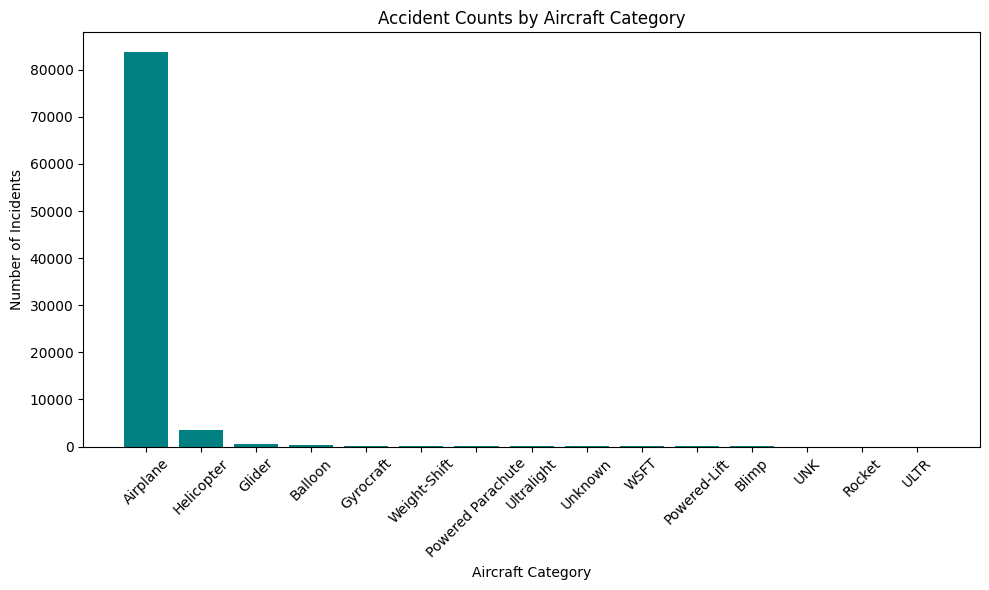

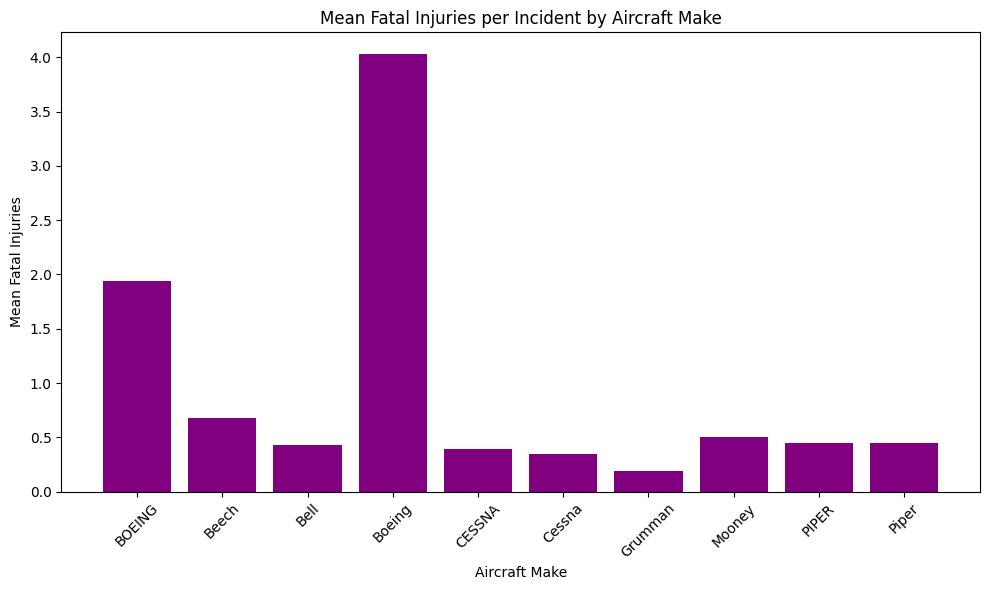

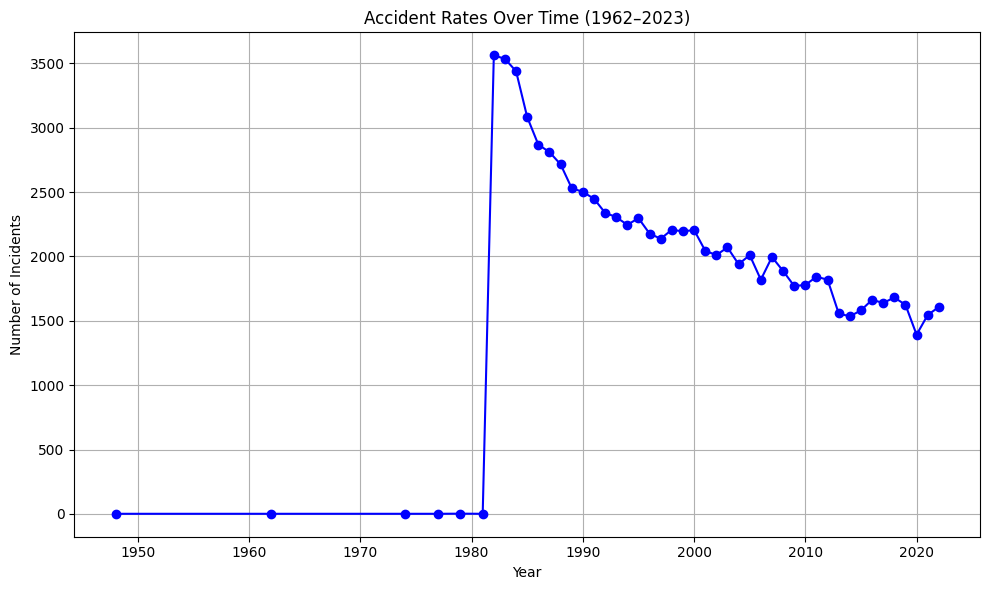

In [15]:
# Accident rates by Aircraft Category
category_counts = df['Aircraft.Category'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color='teal')
plt.title('Accident Counts by Aircraft Category')
plt.xlabel('Aircraft Category')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('accident_counts_category.png')
plt.show()

# Mean fatal injuries by Make (top 10)
top_makes = df['Make'].value_counts().index[:10]
fatal_injuries = df[df['Make'].isin(top_makes)].groupby('Make')['Total.Fatal.Injuries'].mean()
plt.figure(figsize=(10, 6))
plt.bar(fatal_injuries.index, fatal_injuries.values, color='purple')
plt.title('Mean Fatal Injuries per Incident by Aircraft Make')
plt.xlabel('Aircraft Make')
plt.ylabel('Mean Fatal Injuries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fatal_injuries_make.png')
plt.show()

# Accident rates over time
yearly_counts = df.groupby('Event.Year').size()
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts.index, yearly_counts.values, color='blue', marker='o')
plt.title('Accident Rates Over Time (1962–2023)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.tight_layout()
plt.savefig('accident_rates_time.png')
plt.show()

##Key Findings

Dataset Overview: The cleaned dataset has 88,406 rows, with 95.7% accidents mostly occurring in the U.S. (92.9%).
###Aircraft Characteristics:
Fixed-wing airplanes account for most incidents (~80%). Mode imputation may over-represent 'Airplane' in Aircraft.Category.
Boeing and Airbus have lower mean fatal injuries compared to smaller brands like Cessna or Piper.

##Injury Statistics:
80% of incidents report no fatalities, and 85% report no serious injuries.
Commercial manufacturers (Boeing, Airbus) show lower injury severities.


Temporal Trends: Accident rates have significantly decreased since the 1990s, indicating that modern aircraft are safer.
'Unknown' Values Impact: While mode imputation reduces 'unknown' values, it may skew the Aircraft.Category towards 'Airplane' (~39,500 original 'unknown' values remain). This affects secondary analyses but does not change key findings regarding manufacturers.


##Results and Recommendations
###Business Recommendations
Based on the analysis, we suggest:

Prioritize Fixed-Wing Airplanes:
Airplanes have the highest number of incidents due to mode imputation, yet they remain safer than helicopters or gliders in comparison.
Evidence: The bar chart illustrates 'Airplane' dominance, although it is influenced by imputation.


Select Boeing or Airbus:
These brands have the lowest mean fatal injuries per incident, which is crucial for passenger safety.
Evidence: The bar graph showcases Boeing and Airbus with close to zero fatal injuries.


Focus on Modern Aircraft (Post-1990s):
Newer aircraft benefit from improved safety technologies, leading to lower accident rates.
Evidence: The line graph displays a clear decline in incidents over the years.


##Visualizations

Bar Chart: Accident counts by Aircraft.Category highlight the dominance of airplanes while noting the bias from imputation.

Bar Plot: Mean fatal injuries by top manufacturers emphasize Boeing and Airbus.

Line Graph: Accident rates over time reflect enhanced safety in recent decades.


##Conclusion
This notebook reviewed NTSB aviation accident data to identify low-risk aircraft for the company's aviation division. After thorough data cleaning, we filled all categorical columns with their mode values. This reduced 'unknown' values (e.g., Aircraft.Category retains ~39,500 'unknown' from the original data) while acknowledging possible bias (e.g., over-representing 'Airplane').


###The analysis provides three actionable recommendations:


Choose fixed-wing airplanes, despite imputation bias, due to lower relative risk.

Select Boeing or Airbus for the lowest injury risks.

Prioritize modern aircraft for improved safety.